Next, we want to see whether scLEMBAS can capture the heterogeneity of cell responses upon ligand exposure. 

In [7]:
import os

import numpy as np
import pandas as pd

import scanpy as sc
from sklearn.neighbors import NearestCentroid
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

import sys

lembas_path = '/nobackup/users/hmbaghda/Software/LEMBAS'
# sys.path.insert(1, lembas_path)
# from Model import bionetwork as bionetwork_og
# from Demo.src import bionetwork as bionetwork_og
# from Model import bionetwork

sclembas_path = '/home/hmbaghda/Projects/scLEMBAS/scLEMBAS'
sys.path.insert(1, os.path.join(sclembas_path))
from Model.bionetwork import SignalingModel

In [2]:
n_cores = 12
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

seed = 888
data_path = '/nobackup/users/hmbaghda/scLEMBAS/analysis'

In [3]:
tf_adata = sc.read_h5ad(os.path.join(data_path, 'processed', 'ID_tf_activity.h5ad'))

The simplest scenario is no ligand and exposure to one ligand at uniform concentration, leading to distinct clusters in TF activity space (the prediction output). Thus, let's start with this. To identify the two most distinct clusters, let's calculate the Euclidean distance of the cluster centroids in PC space:

In [4]:
group_label = 'TF_clusters' # ordered cateogry in obs

clf = NearestCentroid()
clf.fit(tf_adata.obsm['X_pca'][:, :tf_adata.uns['pca']['pca_rank']], np.array(tf_adata.obs[group_label]))
centroids = clf.centroids_ # group labels x n_pcs
ped = squareform(pdist(centroids, 'euclidean')) # euclidean distance between all centroids
max_clusters = np.unravel_index(np.argmax(ped), ped.shape)
max_clusters = [clf.classes_[i] for i in max_clusters]
print('Centroid euclidean distance in PC space is maximized between cluster {} and {} ({} PCs)'.format(*max_clusters, tf_adata.uns['pca']['pca_rank']))

Centroid euclidean distance in PC space is maximized between cluster 11 and 15 (8 PCs)


/nobackup/users/hmbaghda/Software/miniforge3/envs/scLEMBAS/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/nobackup/users/hmbaghda/Software/miniforge3/envs/scLEMBAS/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nobackup/users/hmbaghda/Software/miniforge3/envs/scLEMBAS/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired v

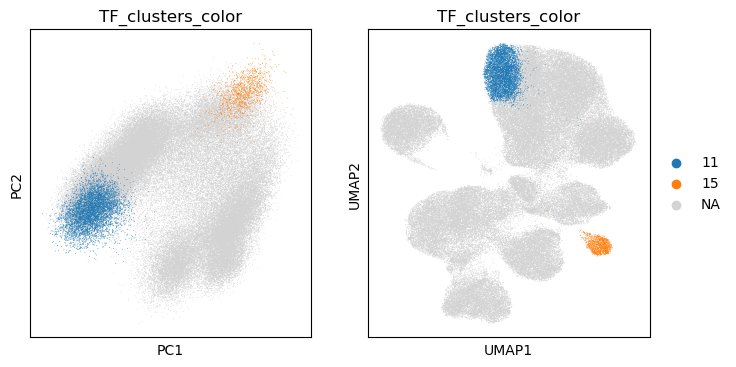

In [7]:
viz_adata = tf_adata.copy()
viz_adata.obs[group_label + '_color'] = pd.Categorical(viz_adata.obs[group_label], 
                                                       categories = max_clusters, 
                                                       ordered = True)
fig, ax = plt.subplots(ncols = 2, figsize = (8, 4))
sc.pl.pca(viz_adata, color=group_label + '_color', ax = ax[0], show = False)
ax[0].legend().set_visible(False)
sc.pl.umap(viz_adata, color=group_label + '_color', ax = ax[1])


Thus, we will proceed with the TF clusters 11 and 15, stating that cluster 11 corresponds to a control (no ligand) and cluster 15 corresponds to an input ligand (at uniform concentration). 

Load and parse the signaling network database:

In [5]:
# load the signaling network database
net = pd.read_csv(os.path.join(lembas_path, 'Demo', 'data','ToyNetRecurrent-Model.txt'), sep = '\t', index_col = False)
net['stimulation'] = net['stimulation'].replace(0, -1)

annotation = pd.read_csv(os.path.join(lembas_path, 'Demo', 'data', 'ToyNetRecurrent-Annotation.txt'), sep='\t', low_memory=False)
ligand_labels = annotation.loc[annotation.ligand, 'name'].values # ligands
tf_labels = annotation.loc[annotation.TF, 'name'].values # transcription factors

Initialize the model

In [8]:
training_parameters = {'iterations': 150, 'clipping': 1, 'leak': 0.01}
test = SignalingModel(net = net, input_labels = ligand_labels, output_labels = tf_labels, 
               input_amplitude = 1, projection_factor = 1.3, 
               weight_label = 'stimulation', source_label = 'source', target_label = 'target', 
                bionet_params = training_parameters)